# Проект Обучение модели классификации комментариев

## Обзор данных

In [1]:
import numpy as np
import pandas as pd
import torch
import transformers

from tqdm import tqdm, notebook
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

from catboost import CatBoostClassifier
from catboost import cv, Pool

import warnings 
warnings.filterwarnings('ignore') #скроем предупреждения

In [2]:
# чтение файла `toxic_comments.csv` и сохранение в переменной `df`
df = pd.read_csv('toxic_comments.csv')

In [3]:
# просмотр 10 случайных строк таблицы `df`
df.sample(10)

,text,toxic
11411,I was advised to return here to inform you of ...,0
68818,But what with banning me from Evertype talk? I...,0
157177,"""\n\nUsing """"bank robber"""" instead of """"crimin...",0
69568,"""==Riddle me this==\nAnswer me something? You ...",0
145463,"Rex, you are really a funny guy... ( )",0
81854,June 2009 \n Please stop your disruptive editi...,0
111716,Urgent complain - Wikipedia \n\nAnswer given b...,0
128647,"""\n\nI have a more serious problem with this l...",0
21070,I removed the barnstar you had given me \n\nI ...,0
135993,""":No problem at all, thanks for clarifying for...",0


In [4]:
#получение общей информации о таблице `df`
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


В таблице 2 столбца. Типы данных в столбцах: object и int64.

Согласно документации к данным:
* `text` — содержит текст комментария;
* `toxic` — отметка о токсичности комментариев пользователей: 1 - токсичный комментарий, 0 - нетоксичный.

Целевой признак - `toxic`.

Названия столбцов соответствуют хорошему стилю.

Количество значений в столбцах одинаковое, значит, пропущенных значений нет.

### Выводы

В каждой строке таблицы содержится текст комментариев пользователей с отметкой об их токсичности. 

Предварительно можно утверждать, что, данных достаточно для выбора модели. Пропусков в данных не обнаружено, название столбца соответствует хорошему стилю.

Чтобы двигаться дальше, нужно подготовить данные для построения моделей.

## Подготовка данных

Наш целевой признак `toxic` (отметка о токсичности комментариев) - является категориальным, поэтому мы будем подбирать модель для решения задачи классификации. Так как в нашем случае признака всего два (токсичный комментарий или нет), то нас интересует бинарная классификация.

Используем модели Логистическая регрессия и CatBoostClassifier. Для кодирования текстов в векторный вид используем нейронную сеть BERT.

### Проверка баланса классов

Проверим данные на сбалансированность классов.

In [5]:
df['toxic'].mean()

0.10167887648758234

0    0.898321
1    0.101679
Name: toxic, dtype: float64


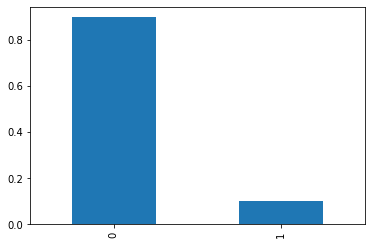

In [6]:
class_frequency = df['toxic'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar');

Данные в таблице не сбалансированы, токсичиных комментариев намного меньше. Попробуем обучить модели на несбалансированных данных. Объём датасета достаточно большой - отберём из датасета 800 строк для обучающей выборки и 200 строк - для тестовой.

In [9]:
train = df.sample(800).reset_index(drop=True)
train.shape

(800, 2)

In [10]:
# баланс классов в обучающей выборке
train['toxic'].mean()

0.11

In [7]:
test = df.sample(200).reset_index(drop=True)
test.shape

(200, 2)

In [8]:
# баланс классов в тестовой выборке
test['toxic'].mean()

0.105

### Подготовка признаков обучающей выборки

In [11]:
# Инициализируем токенизатор как объект класса BertTokenizer(), передадим ему файл со словарём, на котором обучалась модель
tokenizer = transformers.BertTokenizer(
    vocab_file='/Users/evgeniaabaseva/Documents/Study/Yandex/12.Машинное-обучение-для-текстов/toxic-bert/vocab.txt')

In [12]:
# инициализируем модель класса BertModel, передадим ей файл с предобученной моделью и конфигурацией
config = transformers.BertConfig.from_json_file(
    '/Users/evgeniaabaseva/Documents/Study/Yandex/12.Машинное-обучение-для-текстов/toxic-bert/config.json')
model = transformers.BertModel.from_pretrained(
    '/Users/evgeniaabaseva/Documents/Study/Yandex/12.Машинное-обучение-для-текстов/toxic-bert/pytorch_model.bin', config=config)

Some weights of the model checkpoint at /Users/evgeniaabaseva/Documents/Study/Yandex/12.Машинное-обучение-для-текстов/toxic-bert/pytorch_model.bin were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Создадим эмбеддинги BERT для обучающей выборки, установим max_length=512 для того чтобы учесть ограничение BERT на количество слов = 512.

In [13]:
tqdm.pandas()

In [14]:
# преобразуем текст в номера токенов из словаря методом encode()
tokenized = train['text'].progress_apply(
  lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=512, padding="max_length"))

100%|████████████████████████████████████████| 800/800 [00:03<00:00, 262.71it/s]


In [15]:
# проверим максимальную длину вектора в полученной таблице
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
max_len

512

In [16]:
# применим метод padding, чтобы после токенизации длины исходных текстов в корпусе были равными
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

In [17]:
# теперь поясним модели, что нули не несут значимой информации, «создадим маску» - укажем нулевые и не нулевые значения
attention_mask = np.where(padded != 0, 1, 0)

In [18]:
# зададим размер батча
batch_size = 100

# сделаем пустой список для хранения эмбеддингов твитов
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        # преобразуем данные в формат тензоров в библиотеке torch
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        # преобразуем маску
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        # укажем, что градиенты не нужны
        with torch.no_grad():
            # чтобы получить эмбеддинги для батча, передадим модели данные и маску
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        # из полученного тензора извлечём нужные элементы и добавим в список всех эмбеддингов
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/8 [00:00<?, ?it/s]

In [19]:
# соберём все эмбеддинги в матрицу признаков
features_train = np.concatenate(embeddings)
features_train.shape

(800, 768)

### Подготовка признаков тестовой выборки

Создадим эмбеддинги BERT для тестовой выборки.

In [20]:
# преобразуем текст в номера токенов из словаря методом encode()
tokenized_test = test['text'].progress_apply(
  lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=512, padding="max_length"))

100%|████████████████████████████████████████| 200/200 [00:01<00:00, 173.62it/s]


In [21]:
# проверим максимальную длину вектора в полученной таблице
max_len = 0
for i in tokenized_test.values:
    if len(i) > max_len:
        max_len = len(i)
max_len

512

In [22]:
# применим метод padding, чтобы после токенизации длины исходных текстов в корпусе были равными
padded_test = np.array([i + [0]*(max_len - len(i)) for i in tokenized_test.values])

In [23]:
# теперь поясним модели, что нули не несут значимой информации, «создадим маску» - укажем нулевые и не нулевые значения
attention_mask_test = np.where(padded_test != 0, 1, 0)

In [24]:
# зададим размер батча
batch_size = 50

# сделаем пустой список для хранения эмбеддингов твитов
embeddings_test = []

for i in notebook.tqdm(range(padded_test.shape[0] // batch_size)):
        # преобразуем данные в формат тензоров в библиотеке torch
        batch = torch.LongTensor(padded_test[batch_size*i:batch_size*(i+1)]) 
        # преобразуем маску
        attention_mask_batch = torch.LongTensor(attention_mask_test[batch_size*i:batch_size*(i+1)])
        
        # укажем, что градиенты не нужны
        with torch.no_grad():
            # чтобы получить эмбеддинги для батча, передадим модели данные и маску
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        # из полученного тензора извлечём нужные элементы и добавим в список всех эмбеддингов
        embeddings_test.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/4 [00:00<?, ?it/s]

In [25]:
# соберём все эмбеддинги в матрицу признаков
features_test = np.concatenate(embeddings_test)
features_test.shape

(200, 768)

**Выводы**

На данном этапе мы:
1. проверили данные на сбалансированность классов - классы не сбалансированы, для того чтобы сбалансировать классы мы ограничили размер выборки до 2тыс, выбрав случайно по 1000 строк каждого класса, а также сформировали тестовую выборку с учётом дисбаланса классов;
2. создали эмбеддинги для обучающей и тестовой выборок при помощи нейронной сети BERT.

### Подготовка выборок для обучения и тестирования моделей

Разделим наши таблицы на обучающую и тестовую выборки в соотношении 4:1 - 80% обучающая выборка и 20% тестовая выборка.

In [27]:
# сохраним таргеты в отдельные переменные
target_train = train['toxic']
target_test = test['toxic']

print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(800, 768)
(200, 768)
(800,)
(200,)


### Выводы

На данном этапе мы проверили даные на баланс классов - данные в таблице не сбалансированы, приняли решение обучать и тестировать модель на несбалансированных данных; а также подготовили признаки для обучающей и тестовой выборок, применив нейронную сеть BERT для кодирования текстов в векторный вид, и таргеты соответственно.

## Обучение

### LogisticRegression

Подберём значения гиперпараметров для модели Логистическая регрессия, обучим её и оценитм качество.

In [28]:
%%time

logreg = LogisticRegression()

parametrs = {
    'class_weight': ['balanced', 'None'],
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

clf = GridSearchCV(logreg, parametrs, scoring='f1', cv=5, n_jobs = 1, verbose = 0, return_train_score=True)
clf.fit(features_train, target_train)

print('Best parametres:', clf.best_params_)
print('F1:', clf.best_score_)

Best parametres: {'C': 0.1, 'class_weight': 'None', 'penalty': 'l2', 'solver': 'newton-cg'}
F1: 0.9318859167416044
CPU times: user 35.1 s, sys: 3.18 s, total: 38.3 s
Wall time: 20.8 s


Значения гиперпараметров Логистической регрессии для лучшего значения F1 на обучающей выборке: C = 0.1, class_weight = None, penalty = l2, solver = newton-cg.

In [31]:
%%time

model = LogisticRegression(C=0.1, class_weight='None', penalty='l2', solver='newton-cg')
model.fit(features_train, target_train) # обучим модель на тренировочной выборке

# получим предсказания модели на обучающей выборке и посчитаем значение метрики F1 
pred_train = model.predict(features_train)
f1_train = f1_score(target_train, pred_train)

# получим предсказания модели на тестовой выборке и посчитаем значение метрики F1 
pred_test = model.predict(features_test)
f1_test = f1_score(target_test, pred_test)

print('F1 на обучающей выборке:', f1_train)
print('F1 на тестовой выборке:', f1_test)

F1 на обучающей выборке: 0.9714285714285714
F1 на тестовой выборке: 0.9767441860465117
CPU times: user 174 ms, sys: 16.9 ms, total: 191 ms
Wall time: 131 ms


**Выводы**

F1 на обучающей выборке 0.97, на тестовой - 0.97, что удовлетворяет условию задачи (значение метрики F1 должно быть не меньше 0.75), время работы модели = 131 ms. Модель не переобучилась.

### CatBoostClassifier

Подберём значения гиперпараметров для модели CatBoostClassifier, обучим её и оценитм качество.

In [1]:
%%time

model = CatBoostClassifier()

grid = {'learning_rate': [0.01, 0.5],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = model.grid_search(grid, 
                                       X=features_train, 
                                       y=target_train,
                                       cv=3,
                                       plot=True)

print('Best parametres:', clf.params)

In [33]:
# создаём объект для catboost, на котором будем обучать модель
train_data = Pool(data=features_train, label=target_train)

In [34]:
# создаём объект для catboost, на котором будем тестировать модель
test_data = Pool(data=features_test, label=target_test)

In [35]:
# параметры для модели
params = {'eval_metric': 'F1',
          'loss_function': 'Logloss',
          'random_seed': 42,
          'learning_rate': 0.5,
          'depth': 6,
          'l2_leaf_reg': 3,
          'verbose':100,
          'early_stopping_rounds':100}

In [36]:
model = CatBoostClassifier(**params)

In [37]:
model.fit(train_data)

0:	learn: 0.9132948	total: 386ms	remaining: 6m 25s
100:	learn: 1.0000000	total: 14.3s	remaining: 2m 7s
200:	learn: 1.0000000	total: 28.1s	remaining: 1m 51s
300:	learn: 1.0000000	total: 45.4s	remaining: 1m 45s
400:	learn: 1.0000000	total: 57.8s	remaining: 1m 26s
500:	learn: 1.0000000	total: 1m 10s	remaining: 1m 10s
600:	learn: 1.0000000	total: 1m 22s	remaining: 54.9s
700:	learn: 1.0000000	total: 1m 34s	remaining: 40.3s
800:	learn: 1.0000000	total: 1m 46s	remaining: 26.4s
900:	learn: 1.0000000	total: 1m 58s	remaining: 13s
999:	learn: 1.0000000	total: 2m 10s	remaining: 0us


In [38]:
pred_test = model.predict(test_data)
f1_test = f1_score(target_test, pred_test)
f1_test

0.9523809523809523

**Выводы**

F1 на обучающей выборке 1, на тестовой - 0.95, что удовлетворяет условию задачи (значение метрики F1 должно быть не меньше 0.75), время работы модели = 6m 25s. Модель переобучилась.

### Выводы

На данном этапе мы подобрали значения ниперпараметров для моделей LogisticRegression и CatBoostClassifier, обучили их и получили предсказания по обучающей и тестовой выборкам, а также рассчитали значение метрики F1 на обучающей и тестовой выборках.

## Выводы

Составим таблицу сравнения полученных метрик и времени работы моделей.

In [39]:
final = pd.DataFrame({'model': ['LogisticRegression', 'CatBoostClassifier'], 
                      'F1_train': [0.97, 1],
                      'F1_test': [0.97, 0.95],
                      'time': ['131 ms', '6min 25s']})
final

,model,F1_train,F1_test,time
0,LogisticRegression,0.97,0.97,131 ms
1,CatBoostClassifier,1.00,0.95,6min 25s


**Выводы**

Значение метрики F1 на тестовой выборке больше 0.75 у обеих моделей, при этом модель CatBoostClassifier переобучается и отрабатывает гораздо больше времени, чем LogisticRegression. Исходя из полученных результатов предлагается выбрать модель LogisticRegression, значение F1 на тестовой выборке = 0.97.

## Общий вывод

Исследование проводилось в четыре этапа:

* На этапе Обзор данных мы ознакомились с данными в предоставленной таблице и зафиксировали, что предварительно данных для проведения исследования достаточно;
* На этапе Подготовка данных мы проверили даные на баланс классов, подготовили признаки для обучающей и тестовой выборок, применив нейронную сеть BERT для кодирования текстов в векторный вид, и таргеты соответственно;
* На этапе Обучение разных моделей мы подобрали значения ниперпараметров для моделей LogisticRegression и CatBoostClassifier, обучили их, получили предсказания по обучающей и тестовой выборкам и рассчитали значение метрики F1 для каждой из выборок;
* На этапе Выводы мы сформировали итоговую таблицу со значениями метрики F1 на обучающей и тестовой выборках и временем работы моделей, значение метрики F1 на тестовой выборке удовлетворяет условиям проекта у обеих моделей, при этом модель CatBoostClassifier переобучается и отрабатывает гораздо больше времени, чем LogisticRegression.

Исходя из полученных результатов для решения задачи классификации комментариев пользователей на позитивные и негативные интернет-магазина «Викишоп» предлагается выбрать модель LogisticRegression, так как значение F1 на тестовой выборке удовлетворяет условиям проекта (=0.97), при этом для решения данной задачи предлагается не производить балансировку классов.